In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

# set seeds
seed = 7777
np.random.seed(seed)

C:\Users\JanZ\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# study design
# per each day after stress = DAS, 29
# 6 treatments
# 6 replicate plants
# size is 29x36=1044

df = (pd.read_excel('../input/PhenoDataSUM_PILOT2020_NIB.xlsx', skiprows=1) # updated file
      .rename(columns={'Day after Stress Induction/DAS': 'DAS'})
     )
print(df.shape)
print(29*6*6)
df.head(20)

(1044, 25)
1044


,DAS,Plant ID,Replica,Treatment,SIDE-AREA,WIDTH,HEIGHT,TOP-AREA,COMPACTNESS,ROUNDNESS,...,qP,qL,ΔT,PRI,NDVI,SIPI,MCARI,OSAVI,WATER1,WATER CONSUMPTION
0,0,C_P35__1,1,Control,NaN,NaN,NaN,NaN,NaN,NaN,...,0.931136,1.094806,0.487356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,C_P35__2,2,Control,NaN,NaN,NaN,NaN,NaN,NaN,...,0.935363,1.086704,0.254845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,C_P35__3,3,Control,22538.523921,283.511605,333.649948,85530.154067,0.676404,0.099217,...,0.956595,1.059119,0.317326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,C_P35__4,4,Control,23738.560777,297.741917,329.152560,66378.413988,0.693832,0.103960,...,0.953339,1.056840,0.312260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,C_P35__5,5,Control,22706.444980,327.570840,324.092999,76753.878661,0.688258,0.073080,...,0.959459,1.049582,-0.028524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,C_P35__6,6,Control,25811.561497,306.499032,347.704284,97157.198987,0.665279,0.108559,...,0.950779,1.064650,0.154772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,D_P35__1,1,Drought,NaN,NaN,NaN,NaN,NaN,NaN,...,0.926053,1.098277,0.314394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,D_P35__2,2,Drought,NaN,NaN,NaN,NaN,NaN,NaN,...,0.948807,1.069726,0.262518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,D_P35__3,3,Drought,21605.253089,354.115846,367.942529,87474.499451,0.711694,0.112292,...,0.969463,1.041064,0.522541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,D_P35__4,4,Drought,18953.387533,250.946082,347.142111,69650.868965,0.660002,0.117701,...,0.933555,1.086655,0.473764,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# fix treatments
df['DAS'] = df.DAS.astype(int) # assert
print(df.shape)
df = df.query('DAS>0') #.query('Treatment!="Heat + Drought + Waterlogging"') # dead
print(df.shape)

# control=ok
# drought
df.loc[(df.Treatment=='Drought')&(df.DAS<8),'Treatment'] = 'Control'
df.loc[(df.Treatment=='Drought')&(df.DAS>14),'Treatment'] = 'Control'
# heat
df.loc[(df.Treatment=='Heat')&(df.DAS>14),'Treatment'] = 'Control'
# heat+drought
df.loc[(df.Treatment=='Heat + Drought')&(df.DAS<8),'Treatment'] = 'Heat'
df.loc[(df.Treatment=='Heat + Drought')&(df.DAS>14),'Treatment'] = 'Control'
# waterlogging
df.loc[(df.Treatment=='Waterlogging')&(df.DAS>14),'Treatment'] = 'Control'
# HDW
df.loc[(df.Treatment=="Heat + Drought + Waterlogging")&(df.DAS<8),'Treatment'] = 'Heat' #query('Treatment!="Heat + Drought + Waterlogging"') # dead
df.loc[(df.Treatment=="Heat + Drought + Waterlogging")&(df.DAS>8),'Treatment'] = 'Heat + Drought'

# check imbalance pre-subselection
print(df.Treatment.value_counts())


(1044, 25)
(1008, 25)
Control                          546
Heat                             168
Heat + Drought                   162
Waterlogging                      84
Drought                           42
Heat + Drought + Waterlogging      6
Name: Treatment, dtype: int64


# Build classifiers
Note 80/20% split

In [5]:
df['DAS'] = df.DAS.astype(int)
df1 = (df
       .drop(columns=['PRI', 'NDVI',
       'SIPI', 'MCARI', 'OSAVI', 'WATER1']) # dont remove 'WATER CONSUMPTION'
       .dropna()
       #.dropna(subset=['WATER1'])
       .query('Treatment!="Heat + Drought + Waterlogging"') # dead
       .query('DAS<=14') # approx first two weeks
      )
print(df1.shape)
df1 = df1[~((df1.Treatment=='Waterlogging')&(df1.DAS>8))] # remove waterlogging after dat 7
print(df1.shape)
df1 = df1[~((df1.Treatment=='WATER CONSUMPTION')&(df1.DAS<2))] # remove before day 2

print(df1.shape)
print(df1.dropna(how='any').shape) # sanity
df1.groupby(['Plant ID']).Treatment.value_counts()
X = df1.drop(columns=['DAS','Plant ID','Replica','Treatment']).values
xnames = list(df1.drop(columns=['DAS','Plant ID','Replica','Treatment']).columns)
print(X.shape)

# check imbalance
print(df1.Treatment.value_counts())

# encode treatment
keys = df1.Treatment.unique()
values = list(range(df1.Treatment.unique().shape[0]))
dic = dict(zip(keys, values))
print(dic)
y = df1.Treatment.replace(dic)
print(y.shape)

# scale x
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=8675309)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(459, 19)
(423, 19)
(423, 19)
(423, 19)
(423, 15)
Heat              149
Control           112
Heat + Drought     78
Waterlogging       42
Drought            42
Name: Treatment, dtype: int64
{'Control': 0, 'Heat': 1, 'Waterlogging': 2, 'Drought': 3, 'Heat + Drought': 4}
(423,)
(338, 15)
(85, 15)
(338,)


In [6]:
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'] # 'roc_auc' multicalss not supprted
    target_names = dic.keys()
    print(target_names)
    models_trained = []
    for name, model in models:
        print(name,model)
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
    
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        models_trained.append(clf)
        
    final = pd.concat(dfs, ignore_index=True)
    return final, models_trained

final, models_trained = run_exps(X_train, y_train, X_test, y_test)

dict_keys(['Control', 'Heat', 'Waterlogging', 'Drought', 'Heat + Drought'])
LogReg LogisticRegression()
LogReg


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


                precision    recall  f1-score   support

       Control       0.96      1.00      0.98        25
          Heat       0.96      1.00      0.98        25
  Waterlogging       1.00      0.91      0.95        11
       Drought       0.80      0.80      0.80         5
Heat + Drought       1.00      0.95      0.97        19

      accuracy                           0.96        85
     macro avg       0.94      0.93      0.94        85
  weighted avg       0.97      0.96      0.96        85

RF RandomForestClassifier()
RF
                precision    recall  f1-score   support

       Control       1.00      1.00      1.00        25
          Heat       0.93      1.00      0.96        25
  Waterlogging       1.00      1.00      1.00        11
       Drought       1.00      1.00      1.00         5
Heat + Drought       1.00      0.89      0.94        19

      accuracy                           0.98        85
     macro avg       0.99      0.98      0.98        85
  weighted a

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:54:32] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:32] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:54:32] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:32] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:32] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
                precision    recall  f1-score   support

       Control 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [8]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)]
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')


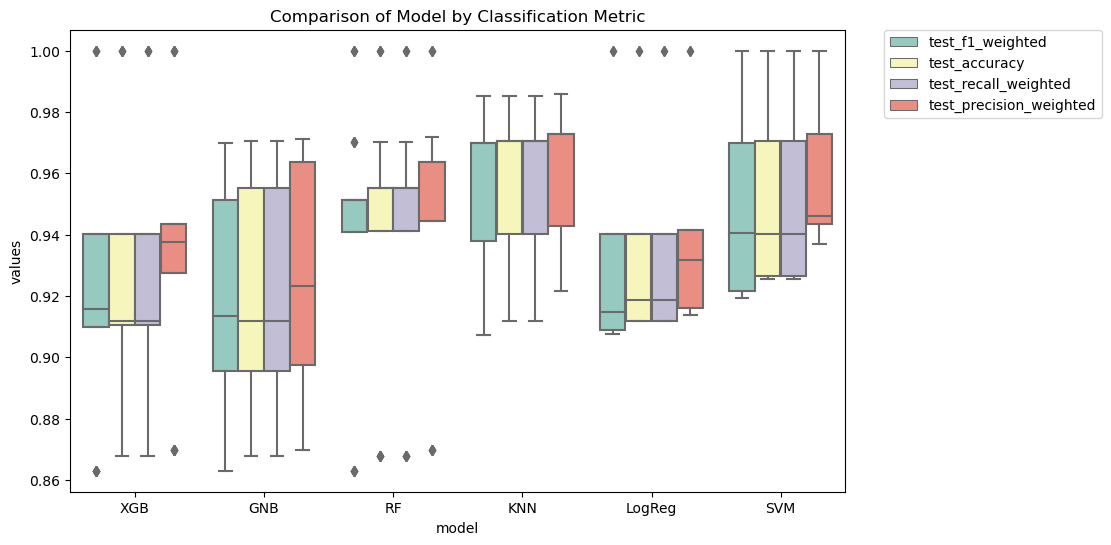

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", 
                data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance-drop_cols-'+
            str(seed)+'.png',dpi=300,bbox_inches='tight')

# Feature selection
methods: 
- anova
- mutual information
- random forest model 3 methods - feature importance, permutation importnace, shap vales


(423, 15) (423,)
(423, 15)
Feature 0: 52.304672 : SIDE-AREA
Feature 1: 127.312259 : WIDTH
Feature 2: 87.446861 : HEIGHT
Feature 3: 212.600809 : TOP-AREA
Feature 4: 359.512487 : COMPACTNESS
Feature 5: 205.241528 : ROUNDNESS
Feature 6: 173.576621 : ISOTROPY
Feature 7: 197.356377 : SOL
Feature 8: 95.529453 : VOLUME_MM^3
Feature 9: 166.238481 : Fv´/Fm´
Feature 10: 132.097600 : ɸPSII
Feature 11: 51.112178 : qP
Feature 12: 168.822869 : qL
Feature 13: 243.502113 : ΔT
Feature 14: 227.908796 : WATER CONSUMPTION


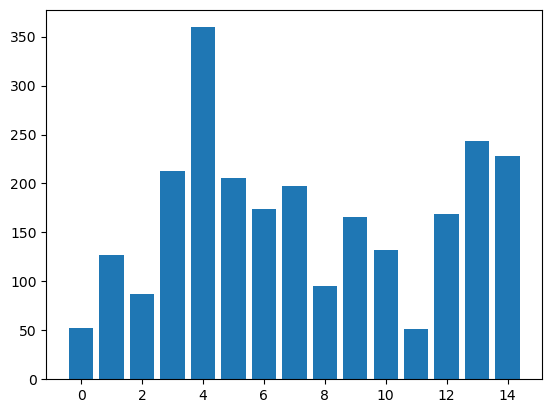

In [11]:
# feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

def normalize(xx):
    return [(x-xx.min())/(xx.max()-xx.min()) for x in xx] 

# anova
# # generate dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=2)
print(X_scaled.shape,y.shape)

# define feature selection
fs = SelectKBest(score_func=f_classif, k='all')
# apply feature selection
X_selected = fs.fit_transform(X_scaled, y)

# define dataframe with results
df_res = pd.DataFrame(xnames,columns=['feature'])
df_res['anova_score'] = normalize(fs.scores_)

# mutual info
# configure to select all features
fs = SelectKBest(score_func=mutual_info_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
df_res['mutinfo_score'] = normalize(fs.scores_)

# get feature importances from rf model
#models_trained[1].feature_importances_
rf = models_trained[1]
df_res['rf_importance'] = normalize(rf.feature_importances_)

perm_importance = permutation_importance(rf, X_test, y_test)
df_res['rf_perm'] = normalize(perm_importance.importances_mean)

In [12]:
def normalize(xx):
    return [(x-xx.min())/(xx.max()-xx.min()) for x in xx]
df_res = pd.DataFrame(xnames,columns=['feature'])
df_res['anova_score'] = normalize(fs.scores_)

Feature 0: 0.376466 : SIDE-AREA
Feature 1: 0.430012 : WIDTH
Feature 2: 0.415836 : HEIGHT
Feature 3: 0.664503 : TOP-AREA
Feature 4: 0.599066 : COMPACTNESS
Feature 5: 0.655688 : ROUNDNESS
Feature 6: 0.464324 : ISOTROPY
Feature 7: 0.507884 : SOL
Feature 8: 0.507252 : VOLUME_MM^3
Feature 9: 0.585836 : Fv´/Fm´
Feature 10: 0.460670 : ɸPSII
Feature 11: 0.472640 : qP
Feature 12: 0.709337 : qL
Feature 13: 0.624634 : ΔT
Feature 14: 0.906489 : WATER CONSUMPTION


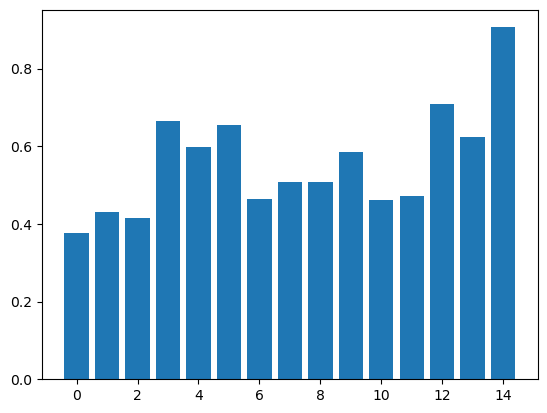

In [13]:
# mutual info
# configure to select all features
fs = SelectKBest(score_func=mutual_info_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]) +' : '+ xnames[i])
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

df_res['mutinfo_score'] = normalize(fs.scores_)

In [14]:
# get feature importances from rf model
#models_trained[1].feature_importances_
rf = models_trained[1]
df_res['rf_importance'] = normalize(rf.feature_importances_)

perm_importance = permutation_importance(rf, X_test, y_test)
df_res['rf_perm'] = normalize(perm_importance.importances_mean)

explainer = shap.TreeExplainer(rf)
#shap_values = explainer.shap_values(X_test)
#np.array(shap_values).mean(axis=1).mean(axis=0) # probably not correct way
#df_res['rf_shap'] = normalize(shap_values) # no go

#https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
from scipy.special import softmax
shap_values = explainer(X_test)
# Calculates the feature importance (mean absolute shap value) for each feature
importances = []
for i in range(shap_values.values.shape[1]):
    importances.append(np.mean(np.abs(shap_values.values[:, i])))
# Calculates the normalized version
#importances_norm = softmax(importances) # strange all equal vals
df_res['rf_shap'] = normalize(np.array(importances))
#df_res


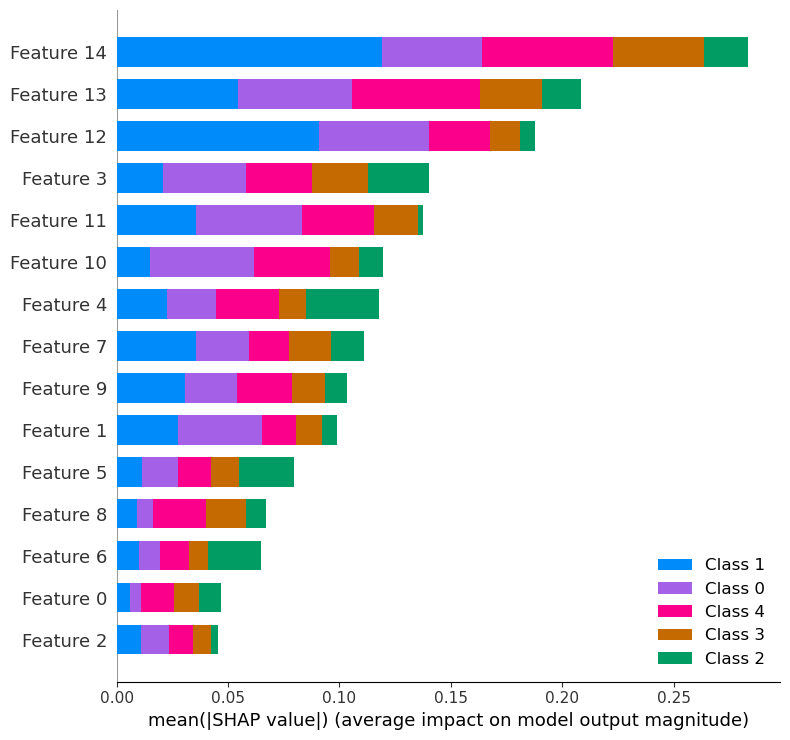

In [15]:
# shap: 
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test) #plot_type="bar"
plt.show()


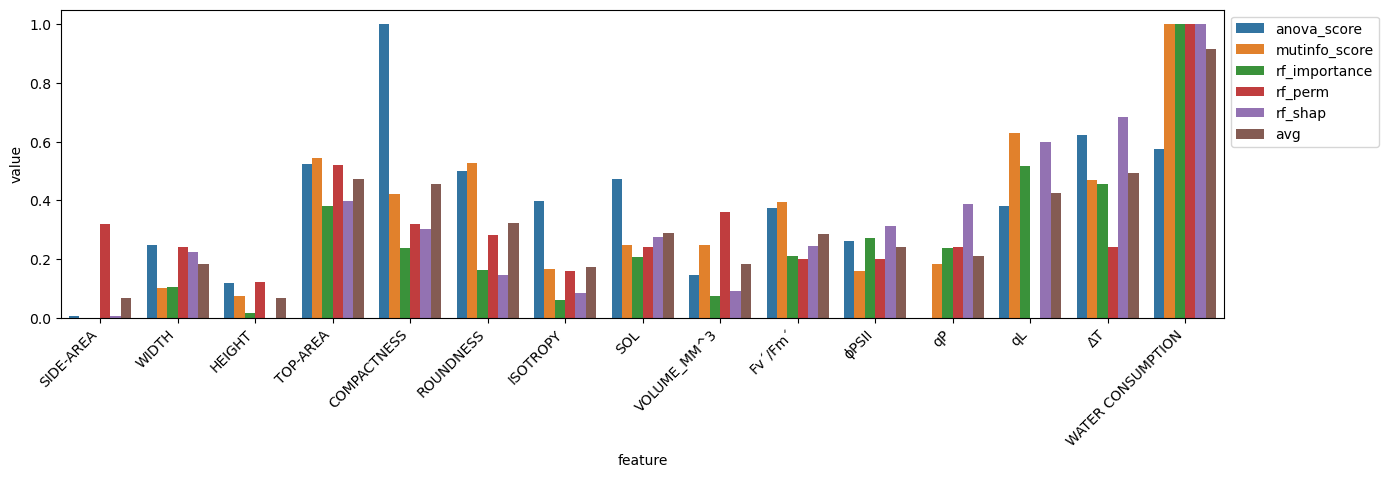

In [16]:
# plot
df_res['avg'] = df_res.iloc[:,1:].mean(axis=1) # add avgs
plt.figure(figsize=(15,4))
sns.barplot(data=df_res.melt(id_vars=['feature'],value_vars=['anova_score',
                                                             'mutinfo_score',
                                                             'rf_importance',
                                                             'rf_perm',
                                                             'rf_shap',
                                                             'avg'
                                                            ]),
            x='feature',y='value',hue='variable')
plt.xticks(rotation=45,ha='right')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('feature_scores-drop_cols-'+str(seed)+'.png',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
df_res.sort_values(by='avg',ascending=False).to_csv('feature_scores-drop_cols-'+str(seed)+'.csv', index=False)
df_res.sort_values(by='avg',ascending=False)

,feature,anova_score,mutinfo_score,rf_importance,rf_perm,rf_shap,avg
14,WATER CONSUMPTION,0.573270,1.000000,1.000000,1.00,1.000000,0.914654
13,ΔT,0.623832,0.468222,0.457039,0.24,0.683874,0.494593
3,TOP-AREA,0.523633,0.543443,0.381955,0.52,0.397750,0.473356
4,COMPACTNESS,1.000000,0.419981,0.238438,0.32,0.303649,0.456414
12,qL,0.381681,0.628031,0.517824,0.00,0.598727,0.425253
5,ROUNDNESS,0.499770,0.526810,0.162906,0.28,0.144846,0.322866
7,SOL,0.474203,0.247948,0.205222,0.24,0.275015,0.288478
9,Fv´/Fm´,0.373302,0.395020,0.211008,0.20,0.243725,0.284611
10,ɸPSII,0.262598,0.158869,0.272814,0.20,0.312247,0.241306
11,qP,0.000000,0.181453,0.235688,0.24,0.386855,0.208799


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


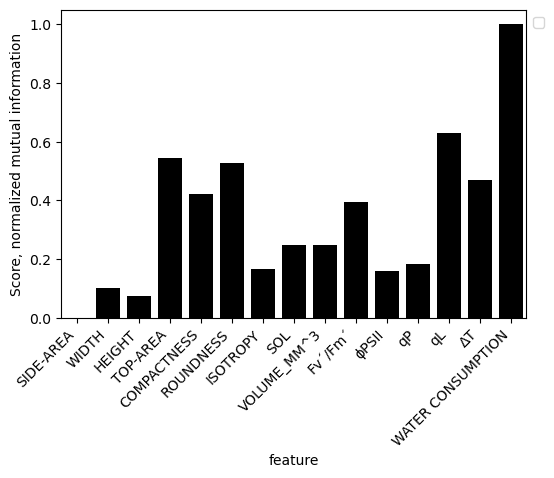

In [19]:
# plot mutual info
df_res['avg'] = df_res.iloc[:,1:].mean(axis=1) # add avgs
plt.figure(figsize=(6,4))
sns.barplot(data=df_res,#.melt(id_vars=['feature'],value_vars=[
                        #                                     'mutinfo_score',
 #                                                           ]),
            x='feature',y='mutinfo_score',
            color='k'
           ) #y='value',hue='variable')
plt.xticks(rotation=45,ha='right')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Score, normalized mutual information')
plt.savefig('mut_info-drop_cols-'+str(seed)+'.png',dpi=300,bbox_inches='tight')
plt.show()